In [54]:
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import logging
logging.Logger.disabled=True

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings;
with warnings.catch_warnings():
    warnings.simplefilter("ignore"); 
    import matplotlib.pyplot as plt

import os
import sys
from pathlib import Path
import IPython
from scipy import signal
import scipy.fftpack
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
from scipy.fft import fft, fftfreq
import numpy as np
import unittest

import schemdraw
import schemdraw.elements as elm

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

directory_path = Path(os.path.abspath('')).resolve()

## amplitude modulation
{: class="is-subtitle is-size-2 is-lowercase is-italic"}

amplitude modulation has its origin in electronic communication technology. it is used in radio transmission where an audio signal is modulated on a carrier signal. amplitude modulation is also used in synthesizers. a vca is a simple form of amplitude modulation, where the carrier signal is modulated with an envelope. when both signals in a vca are in the audio range, the resulting audio signal has added timbre. amplitude modulation is also used in a ring modulator. ring modulation adds frequencies to the audio signal which gives it a different characteristic. the resulting audio signal has some 'metallic' sound. the well-known usage of ring modulation is the [Dalek voice](https://de.wikipedia.org/wiki/Die_Daleks) from the BBC series [Doctor Who](https://de.wikipedia.org/wiki/Doctor_Who). 


in amplitude modulation the amplitude (signal strength) of the carrier changes in proportion to the message signal.  




$$
\begin{array}{c}
c(t) = A \sin(2 \pi f_c t)\,
\end{array}
$$


where A is the amplitude of the carrier singal and the function of f the modulation signal. amplitude modulation is a multiplication of the two signals. 

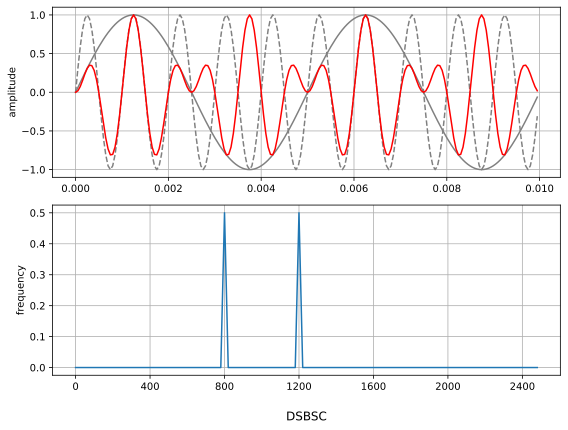

In [55]:
f1 = 1000
f2 = 200

N = 1000
# sample spacing
T = 1.0 / 20000.0
x = np.linspace(0.0, N*T, N, endpoint=False)

y1 = np.sin(f1 * 2.0 * np.pi * x)
y2 = np.sin(f2 * 2.0 * np.pi * x)
y3 = np.sin(f1 * 2.0 * np.pi * x) * np.sin(f2 * 2.0 * np.pi * x)
y4 = np.sin(f1 * 2.0 * np.pi * x) * np.sin(f2 * 2.0 * np.pi * x) + np.sin(f1 * 2.0 * np.pi * x)

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(8, 6))

#plot multiplication
ax0.plot(x[0:200], y1[0:200], c='Grey', linestyle='--')  # differential output
ax0.plot(x[0:200], y2[0:200], c='Grey')  # differential output
ax0.plot(x[0:200], y3[0:200], c='Red')  # differential output
ax0.set_ylabel('amplitude')
ax0.grid()
n = ax1.set_title('DSBSC', y=-0.3)


y = y3
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
ax1.plot(xf[0:125], 2.0/N * np.abs(yf[0:N//8]))
ax1.grid()
ax1.set_ylabel('frequency')
plt.xticks(np.arange(min(xf[0:250]), max(xf[0:125])+1, 400))

plt.tight_layout()
plt.show()


here the carrier frequency is 1kHz and the modulation frequency is 200Hz. The carrier frequency is modulated by the modulation frequency. when the modulation frequency is negative the resulting signal has a phase shift of 90°. the frequency analysis shows that the two sidebands are created at 800Hz and 1200Hz. the modulation frequency is added and subtracted from the base frequency. this is called a double-sideband with suppressed carrier (DSBSC).

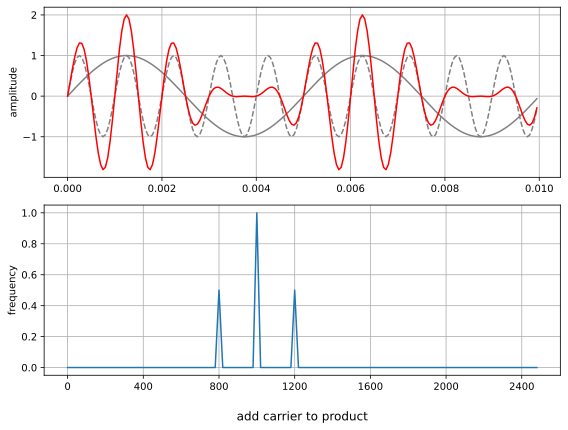

In [56]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(8, 6))

#plot multiplication with carrier added
ax0.plot(x[0:200], y1[0:200], c='Grey', linestyle='--')  # differential output
ax0.plot(x[0:200], y2[0:200], c='Grey')  # differential output
ax0.plot(x[0:200], y4[0:200], c='Red')  # differential output
ax0.grid()
ax0.set_ylabel('amplitude')
n = ax1.set_title('add carrier to product', y=-0.3)

y = y4
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
ax1.plot(xf[0:125], 2.0/N * np.abs(yf[0:N//8]))
ax1.set_ylabel('frequency')
plt.xticks(np.arange(min(xf[0:250]), max(xf[0:125])+1, 400))
ax1.grid()

plt.tight_layout()
plt.show()

when the carrier frequency is added to the result we see two things. first, the final signal is not phase-shifted when the base signal is negative. also, the carrier signal is part of the final signal. this is basic amplitude modulation. but notice that the output amplitude is twice the input.

## Long tailed pair
{: class="is-subtitle is-size-2 is-lowercase is-italic"}

the long-tailed pair or differential amplifier is probably the most widely used circuit building block. for example, the long-tailed pair is the base for op-amps. also in synthesizer circuits, we see the long-tailed pair a lot for converting CV signals into current. this circuit can be implemented with BJTs or MOSFETs. the differential pair multiplies the voltage difference between the two inputs with the differential gain. the differential gain can be configured with the current in the long tail. the output can be taken either from one side or the difference from both sides. 

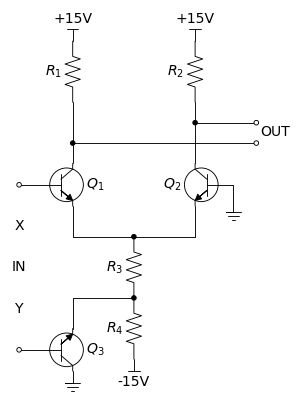

In [57]:
d = schemdraw.Drawing(unit=2.0, inches_per_unit=0.5, lw=0.9)

Q1 = d.add(elm.BjtNpn( label='$Q_1$', circle=True))
d.add(elm.Line("up"))
d.add(elm.Resistor( "up", label="$R_1$"))
d.add(elm.Vdd(label="+15V"))

IN_X = d.add(elm.Line("left", l=d.unit/2, xy=Q1.base))
d.add(elm.Dot('left', open=True))

L_Q1_emmitter = d.add(elm.Line("down",  xy=Q1.emitter, l=d.unit/2))
d.add(elm.Line("right", l=d.unit*2))
d.add(elm.Line("up", l=d.unit/2))
Q2 = d.add(elm.BjtNpn("right", lftlabel='$Q_2$', anchor="emitter", circle=True, reverse=True))
d.add(elm.Line("up", xy=Q2.collector))
d.add(elm.Resistor( "up", label="$R_2$"))
d.add(elm.Vdd(label="+15V"))

d.add(elm.Line("right", xy=Q2.base, l=d.unit/4))
d.add(elm.Line("down", l=d.unit/4))
d.add(elm.Ground())

d.add(elm.Dot(xy=[L_Q1_emmitter.end[0]+d.unit, L_Q1_emmitter.end[1]]))
R3 = d.add(elm.Resistor( "down", label="$R_3$"))
d.add(elm.Dot())
d.add(elm.Resistor( "down", label="$R_4$"))
d.add(elm.Vss(botlabel="-15V"))

d.add(elm.Line("left", l=d.unit, xy=R3.end))
d.add(elm.Line("down", l=d.unit/2))
Q3 = d.add(elm.BjtNpn("right", rgtlabel='$Q_3$', anchor="emitter", circle=True, flip=True))
d.add(elm.Ground(xy=Q3.collector))
IN_Y = d.add(elm.Line("left", xy=Q3.base, tox=IN_X.end))
d.add(elm.Dot('left', open=True))
d.add(elm.Gap('down', xy=IN_X.end, toy=IN_Y.end, label=['X', 'IN', 'Y']))

d.add(elm.Dot(xy=[Q1.collector[0], Q1.collector[1]+d.unit/3]))
L_OUT_A = d.add(elm.Line("right", l=d.unit*3))
d.add(elm.Dot('right', open=True))
d.add(elm.Dot(xy=[Q2.collector[0], Q2.collector[1]+d.unit/3*2]))
L_OUT_B = d.add(elm.Line("right", tox=L_OUT_A.end))
d.add(elm.Dot('right', open=True))

d.add(elm.Label('right', xy=[L_OUT_A.end[0]+d.unit/4, L_OUT_A.end[1]+d.unit/8], label='OUT'))

d.draw()

in this typical vca configuration, the audio signal is applied to the transistor Q1 where Q2 is grounded. the multiplication factor, or current, is set with the transistor Q3. the output is the difference of OUTa and OUTb (OUTb - OUTa). 

In [58]:
circuit = Circuit('differential pair')
circuit.include(spice_library['BC547B'])

circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', '-15V', circuit.gnd, 'DC -15')
circuit.V('3', 'IN_a', circuit.gnd, 'DC 0V AC 0V SIN(0 25m 1k)')
circuit.V('4', 'IN_b', circuit.gnd, 'DC 0V AC 0V SIN(0 5 100)')

circuit.BJT('1', 'OUT_A', 'IN_a', 'R3_in', model="BC547B")
circuit.BJT('2', 'OUT_B', circuit.gnd, 'R3_in', model="BC547B")
circuit.BJT('3', circuit.gnd, 'IN_b', 'R3_out', model="BC547B")

circuit.R(1, 'OUT_A', '+15V', 15@u_kΩ)
circuit.R(2, 'OUT_B', '+15V', 15@u_kΩ)
circuit.R(3, 'R3_in', 'R3_out', 33@u_kΩ)
R4 = circuit.R(4, 'R3_out', '-15V', 15@u_kΩ)


In [59]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=20@u_ms)

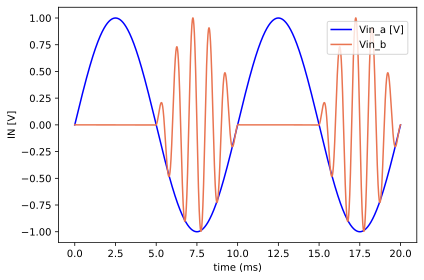

In [60]:
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time (ms)')
ax1_buffer.set_ylabel('IN [V]')
#ax1_buffer.plot(u_ms(analysis['IN_a'].abscissa), analysis['IN_a'], color='Blue')
ax1_buffer.plot(u_ms(analysis['IN_b'].abscissa), analysis['IN_b'] / 5, color='Blue')
#ax1_buffer.plot(u_ms(analysis['OUT_A'].abscissa), analysis['OUT_A'], color='Grey')
#ax1_buffer.plot(u_ms(analysis['OUT_A'].abscissa), analysis['OUT_B'], color='Grey')
ax1_buffer.plot(u_ms(analysis['OUT_A'].abscissa), analysis['OUT_B'] - analysis['OUT_A'], color='#E97451')
ax1_buffer.legend(('Vin_a [V]', 'Vin_b', 'Vout [V]'), loc=(0.75,0.8))

plt.tight_layout()
plt.show()

the output (red) is the signal multiplied by the input at the long tail. but we see that only the negative signal creates amplification. when the signal is positive the output is silent. this circuit can be useful for a vca where a positive envelope is applied.

## gilbert cell
{: class="is-subtitle is-size-2 is-lowercase is-italic"}

another circuit for the multiplication of two signals is the gilbert cell. although everybody calls it the gilbert cell it is not invented by [barrie gilbert](https://en.wikipedia.org/wiki/Barrie_Gilbert). the circuit was first used by Howard Jones in 1963. but barrie gilbert invented and augmented it independently and made it a common building block in analog electronics. the gilbert cell essentially comprises two differential transistor pairs whose bias current is controlled by one of the input signals.

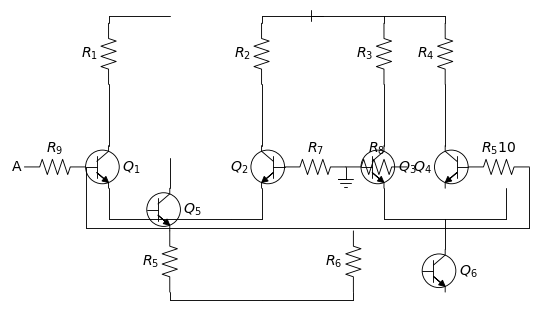

In [61]:
d = schemdraw.Drawing(unit=2.0, inches_per_unit=0.5, lw=0.9)

Q1 = d.add(elm.BjtNpn( label='$Q_1$', circle=True))
R9 = d.add(elm.Resistor( "left", label="$R_9$", xy=Q1.base, lftlabel="A"))

d.add(elm.Line("up", xy=Q1.collector, l=d.unit))
d.add(elm.Resistor("up", label="$R_1$"))
d.add(elm.Line("up", l=d.unit/8))
d.add(elm.Line("right", l=d.unit))

d.add(elm.Line("down", xy=Q1.emitter, l=d.unit/2))
L1 = d.add(elm.Line("right", l=d.unit*2))
d.add(elm.Line("right", l=d.unit/2))
d.add(elm.Line("up", l=d.unit/2))
Q2 = d.add(elm.BjtNpn( "right", lftlabel='$Q_2$', circle=True, anchor='emitter', reverse=True))
d.add(elm.Line("up", l=d.unit, xy=Q2.collector))
d.add(elm.Resistor("up", label="$R_2$"))
d.add(elm.Line("up", l=d.unit/8))
L2 = d.add(elm.Line("right", l=d.unit))
d.add(elm.Vdd("up"))

L3 = d.add(elm.Line("right", xy=L2.end, l=d.unit))
d.add(elm.Line("down", l=d.unit/8))
d.add(elm.Resistor("down", label="$R_3$"))
d.add(elm.Line("down", l=d.unit))
Q3 = d.add(elm.BjtNpn( "right", label='$Q_3$', circle=True, anchor='collector'))

R7 = d.add(elm.Resistor("right", label="$R_7$", xy=Q2.base, l=d.unit))
d.add(elm.Resistor("right", label="$R_8$", l=d.unit))
d.add(elm.Ground(xy=R7.end))

d.add(elm.Line("down", xy=Q3.emitter, l=d.unit/2))
L5 = d.add(elm.Line("right", l=d.unit))
d.add(elm.Line("right", l=d.unit))
d.add(elm.Line("up", l=d.unit/2))

L4 = d.add(elm.Line("right", xy=L3.end, l=d.unit))
d.add(elm.Line("down", l=d.unit/8))
d.add(elm.Resistor("down", label="$R_4$"))
d.add(elm.Line("down", l=d.unit))
Q4 = d.add(elm.BjtNpn( "right", lftlabel='$Q_4$', circle=True, anchor='collector', reverse=True))

d.add(elm.Resistor("right", label="$R_510$", xy=Q4.base))
d.add(elm.Line("down", l=d.unit))
d.add(elm.Line("left", tox=R9.start))
d.add(elm.Line("up", l=d.unit))

d.add(elm.Line("down", xy=L1.start+d.unit, l=d.unit/2))
Q5 = d.add(elm.BjtNpn( "right", label='$Q_5$', circle=True, anchor='collector'))
d.add(elm.Resistor("down", label="$R_5$", xy=Q5.emitter))
d.add(elm.Line("down", l=d.unit/8))
d.add(elm.Line("right", l=d.unit*1.5))
d.add(elm.Line("right", l=d.unit*1.5))
d.add(elm.Line("up", l=d.unit/8))
d.add(elm.Resistor("up", label="$R_6$"))


d.add(elm.Line("down", xy=L5.end, l=d.unit/2))
Q6 = d.add(elm.BjtNpn( "right", label='$Q_6$', circle=True, anchor='collector'))

d.draw()

In [62]:
d = schemdraw.Drawing(
    Q1 := elm.BjtNpn(circle=True).label('$Q_1$'),
    elm.Line().left().at((Q1, 'base')),
    elm.Line().up().at((Q1, 'collector')),
    R1 := elm.Resistor().up().label('$R_{1}$'),
    L1 := elm.Line().right().length(d.unit*2),
    elm.Vdd().label('+15V'),
    elm.Line().right().length(d.unit*2),
    ( R2 := elm.Resistor().down().label('$R_{2}$') ),
    elm.Line().down(),
    Q4 := elm.BjtNpn(circle=True, anchor='collector').left().flip().label('$Q_4$'),

    elm.Line().right().length(d.unit/2).at((Q4, 'base')),
    elm.Line().down().length(d.unit/2),
    elm.Line().left().length(d.unit*6),
    elm.Line().up().length(d.unit/2),
    elm.Dot(),

    elm.Dot().at((R1, 'start')),
    OUTa := elm.Line().right(),
    elm.Dot(open=True),
    elm.Dot().at((R2, 'end')),
    OUTb := elm.Line().left(),
    elm.Dot(open=True),
    elm.Gap().at((OUTa, 'end')).label('OUT'), #.to(OUTb.start)

    elm.Line().down().at((Q1, 'emitter')).length(d.unit/2),
    L2 := elm.Line().right().length(d.unit/2),
    elm.Dot(),
    elm.Line().down().length(d.unit/2),
    Q5 := elm.BjtNpn(circle=True, anchor='collector').right().label('$Q_5$'),
    elm.Line().down().length(d.unit/2).at((Q5, 'emitter')),
    elm.Line().right().length(d.unit*2),
    elm.Dot(), 
    elm.Vss().label('-15V'),
    elm.Line().right().length(d.unit),
    elm.Line().up().length(d.unit/2),
    Q6 := elm.BjtNpn(circle=True, anchor='emitter').right().label('$Q_6$'),
    L4 := elm.Line().up().length(d.unit/2),
    elm.Dot(),
    elm.Line().left().length(d.unit/2),
    elm.Line().up().length(d.unit/2),
    Q3 := elm.BjtNpn(circle=True, anchor='emitter').right().label('$Q_3$'),
    elm.Line().up().at((Q3, 'collector')).length(d.unit/2-d.unit/8),
    elm.Line().left().length(d.unit*3),
    elm.Dot(),
    elm.Line().right().length(d.unit/2).at((L4, 'end')),
    elm.Line().up().length(d.unit/2),

    elm.Line().right().length(d.unit/2).at((L2, 'end')),
    elm.Line().up().length(d.unit/2),
    Q2 := elm.BjtNpn(circle=True, anchor='emitter').left().flip().label('$Q_2$'),
    elm.Line().up().at((Q2, 'collector')).length(d.unit/2),
    elm.Line().right().length(d.unit*3),
    elm.Dot(),

    elm.Line().right().at((Q2, 'base')).length(d.unit*1.5),
    elm.Line().down().at([(Q2, 'base')[0], (Q2, 'base')[1]]).length(d.unit/2),
    elm.Ground(),

    #L3 := elm.Line().right().length(d.unit/2).at((L2, 'end')),
    #elm.Line().right().length(d.unit/2),

    #elm.Dot(),




    #elm.Resistor().down().at((L3, 'end')),
    #elm.Ground()
    )


d.draw()


AttributeError: lftlabel not defined in Element

## Analogue Multiplier
{: class="is-subtitle is-size-2 is-lowercase is-italic"}

we saw that multiple types of multiplier circuits behave differently. of course, this is a well-defined behaviour. the multiplier is classified by three types. the types are called quadrants. in the following table the different quadrants are listed and for which signal type they can be used.


|Type|X [V]| Y  [V]| Out [V]|
|--- |---  |---    |---     |
|1-Quadrant|Unipolar|Unipolar|Unipolar|
|2-Quadrant|Bipolar|Unipolar|Bipolar|
|4-Quadrant|Bipolar|Bipolar|Bipolar|
{: class="table is-striped is-hoverable is-narrow has-text-centered"}


the simulation showed that the long-tailed pair is a 2-quadrant multiplier. the X signal can be an audio signal but the Y signal has to be unipolar, for example, an envelope. in contrast, the gilbert cell is a four-quadrant multiplier and allows both signals to be bipolar. the gilbert cell can be used as a ring modulator. of course a 4-quadrant multiplier also works correctly when one signal is unipolar. but the output signal would be the same as with a 2-quadrant multiplier. 


## conclusion
{: class="is-subtitle is-size-2 is-lowercase is-italic"}

there are different circuits for multiplication of signals. the choice of the circuit depends on the nature of the signal and the required functions we want to apply to them. here only circuits using BJT's are shown. the downside of the circuit is that all the transistors have to be properly matched. in my experience, they are also very sensitive to noise. my take on a discrete gilbert cell produced to much noise to be useful. there are still integrated circuits available implementing the gilbert cell. one example is the AD633 from analogue devices. this chip is very handy, it offers the right input and output impedances. No buffering of the signals is necessary. it is a very precise multiplier, which of course has some price.




## references
{: class="is-subtitle is-size-2 is-lowercase is-italic"}

* [Rod Elliott (ESP)](https://sound-au.com/project204.htm) Frequency Shifter For Acoustic Feedback Reduction
* [Rod Elliott (ESP)](https://sound-au.com/articles/vca-techniques.html) VCA Techniques Investigated


